# 自动微分模块

> 训练神经网络时，框架会根据设计好的模型构建一个计算图（computational graph），来跟踪计算是哪些数据通过哪些操作组合起来产生输出，并通过反向传播算法来根据给定参数的损失函数的梯度调整参数（模型权重）。
> PyTorch 具有一个内置的微分引擎`torch.autograd`以支持计算图的梯度自动计算。

In [2]:
import torch

# 输入x
x = torch.tensor(10.)
# 目标值y
y = torch.tensor(3.).reshape(1, 1)

# 初始化权重w
w = torch.rand(1, 1, requires_grad=True)
# 初始化偏置b
b = torch.rand(1, 1, requires_grad=True)

z = w * x + b

# 设置损失函数
loss = torch.nn.MSELoss()
loss_value = loss(z, y)

# 反向传播
loss_value.backward()

# 打印w，b的梯度
w.grad, b.grad

(tensor([[93.8544]]), tensor([[9.3854]]))

该计算图中x、w、b 为叶子节点，即最基础的节点。叶子节点的数据并非由计算生成，因此是整个计算图的基石,叶子节点张量不可以执行`in-place`操作。而最终的loss为根节点。

可通过`is_leaf`属性查看张量是否为叶子节点：

In [3]:
print(x.is_leaf)
print(w.is_leaf)
print(b.is_leaf)
print(z.is_leaf)
print(y.is_leaf)
print(loss_value.is_leaf)

True
True
True
False
True
False


自动微分的关键就是记录节点的数据与运算。数据记录在张量的`data`属性中，计算记录在张量的`grad_fn`属性中。

计算图根据搭建方式可分为静态图和动态图，PyTorch是动态图机制，在计算的过程中逐步搭建计算图，同时对每个Tensor都存储`grad_fn`供自动微分使用。

若设置张量参数`requires_grad=True`，则PyTorch会追踪所有基于该张量的操作，并在反向传播时计算其梯度。依赖于叶子节点的节点，`requires_grad`默认为True。当计算到根节点后，在根节点调用`backward()`方法即可反向传播计算计算图中所有节点的梯度。

非叶子节点的梯度在反向传播之后会被释放掉（除非设置参数`retain_grad=True`）。而叶子节点的梯度在反向传播之后会保留（累积）。通常需要使用`optimizer.zero_grad()`清零参数的梯度。

有时我们希望将某些计算移动到计算图之外，可以使用`Tensor.detach()`回一个新的变量，该变量与原变量具有相同的值，但丢失计算图中如何计算原变量的信息。换句话说，梯度不会在该变量处继续向下传播。
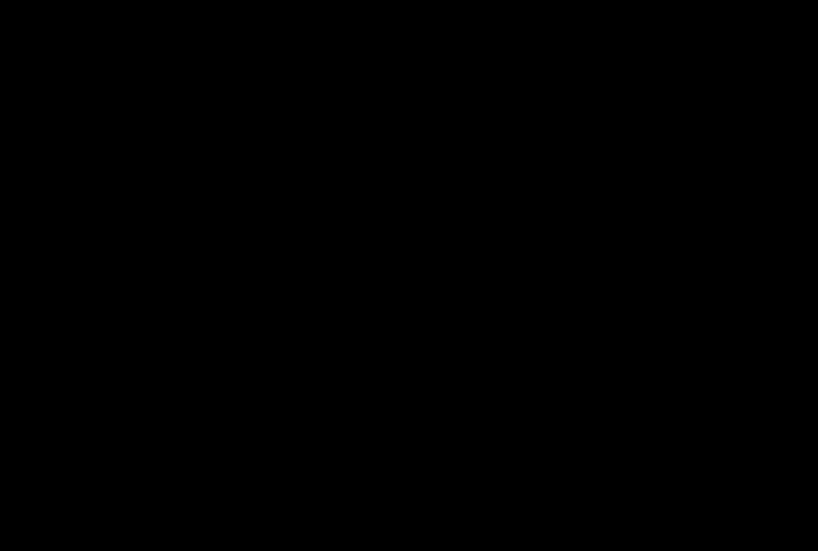

In [6]:
x = torch.normal(mean=10, std=2, size=(2, 2), requires_grad=True)
y = x * x
u = y.detach()  # 分离y得到一个新变量

z = u * x
z.sum().backward()
# 反向传播函数计算z=u*x关于x的偏导数时将u作为常数处理，而不是z=x*x*x关于x的偏导数
x, y, z, u, x.grad == u

(tensor([[10.1341, 10.7240],
         [ 8.9739,  7.9776]], requires_grad=True),
 tensor([[102.6998, 115.0045],
         [ 80.5315,  63.6413]], grad_fn=<MulBackward0>),
 tensor([[1040.7698, 1233.3101],
         [ 722.6839,  507.7021]], grad_fn=<MulBackward0>),
 tensor([[102.6998, 115.0045],
         [ 80.5315,  63.6413]]),
 tensor([[True, True],
         [True, True]]))